## Statistical Learning and Deep Learning HW4

Load dataset.

In [1]:
# load packages
import pickle
from sklearn import preprocessing
%matplotlib inline

# load data
with open('msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if doscaling == 1:
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print()
print("Y_train shape = ", Y_train.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print()
print("X_test shape = ", X_test.shape)
print("Y_test shape = ", Y_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)

Y_train shape =  (463715,)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)

X_test shape =  (51630, 90)
Y_test shape =  (51630,)


### Q1. Oridinary Least Square (OLS)

In [2]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

ols = sm.OLS(Y_train, X_train, hasconst=True)
ols_result = ols.fit()

In [3]:
print(f'The first 5 parameters: {ols_result.params[:5]}')

The first 5 parameters: [ 5.30975265 -2.88088114 -1.53234348  0.05737583 -0.33952889]


In [4]:
# predict
Y_predict = ols_result.predict(X_test)
print(f'The predicted Y is {Y_predict}')

The predicted Y is [-5.81070695  0.03250657  5.13960445 ... -1.39829429 -0.26047668
  0.05193056]


In [5]:
# RMSE
print(f'RMSE = {mean_squared_error(Y_test, Y_predict, squared=False)}')

RMSE = 9.510160684544402


### Q2. MLP with Four Hidden Layers

In [47]:
import numpy as np
import torch
from torch.utils import data
import os
from sklearn.metrics import mean_squared_error

print('torch version:', torch.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')
print(torch.cuda.current_device())

torch version: 1.7.1rc2
using cuda
0


In [48]:
# define dataset
class Dataset(data.Dataset):
    
  def __init__(self, Xnp, Ynp):
        self.labels = Ynp
        self.nobs = Xnp.shape[0]        
        self.Xnp = Xnp
        self.Ynp = Ynp
        
  def __len__(self):
        return self.nobs
    
  def __getitem__(self, index):     
        X = self.Xnp[index]
        y = self.Ynp[index]
        return X, y

In [58]:
# create dataloader
subtrain_set = Dataset(X_subtrain, Y_subtrain)    
valid_set = Dataset(X_valid, Y_valid)
test_set = Dataset(X_test, Y_test)
print('subtrain length', len(subtrain_set))
print('valid length', len(valid_set))
print('test length', len(test_set))

batch_size = 1000
subtrain_loader = data.DataLoader(subtrain_set, batch_size=batch_size)
valid_loader = data.DataLoader(valid_set, batch_size=batch_size)
test_loader = data.DataLoader(test_set, batch_size=batch_size)

subtrain length 417344
valid length 46371
test length 51630


In [78]:
# train

def RMSE(model, data_loader):
    n_obs = 0
    sse = 0
    with torch.no_grad():
        for _batch, (_inputs, _targets) in enumerate(data_loader):
            _targets = _targets.reshape((-1, 1))
            _inputs, _targets = _inputs.to(device), _targets.to(device)
            _outputs = model(_inputs)
            n_obs += _targets.shape[0]
            sse += (_targets - _outputs).pow(2).sum(0)
    return np.sqrt(sse.cpu().numpy()[0] / n_obs)

    
def train(model, optim, loss_f, max_epoch, max_step, valid_interval, weight_path, train_rmse):
    
    step_count = 0
    best_step_count = 0
    best_valid_rmse = np.inf
    all_train_rmse = []
    all_valid_rmse = []
    all_step = []

    for epoch in range(1, max_epoch+1):
        for batch, (inputs, targets) in enumerate(subtrain_loader):

            targets = targets.reshape((-1, 1))
            inputs, targets = inputs.to(device), targets.to(device)
            MLP.to(device)
            MLP.train()
            optim.zero_grad()
            outputs = MLP(inputs)
            loss = loss_f(outputs, targets)
            loss.backward()
            optimizer.step()
            step_count += 1

            # check train/validation RMSE
            if (step_count % valid_interval == 0):

                # subtrain, validation RMSE
                if train_rmse:
                    train_rmse = RMSE(MLP, subtrain_loader)
                    all_train_rmse.append(train_rmse)
                valid_rmse = RMSE(MLP, valid_loader)
                all_valid_rmse.append(valid_rmse)
                all_step.append(step_count)

                # update weight
                if valid_rmse < best_valid_rmse:
                    best_step_count = step_count
                    best_valid_rmse = valid_rmse
                    torch.save(MLP, weight_path)

                # early stopping
                elif (step_count - best_step_count >= max_step):
                    print(f'early stopping, step {step_count}, validation RMSE = {valid_rmse}')
                    return all_step, all_train_rmse, all_valid_rmse
                
        print(f'Epoch {epoch}, Step {step_count}: Loss = {loss.item()}, best_valid_rmse = {best_valid_rmse}')
    return all_step, all_train_rmse, all_valid_rmse

In [79]:
# create MLP model
d_hidden = 45
d_input = subtrain_set.Xnp.shape[1]
d_output = 1

mlp = torch.nn.Sequential(
    torch.nn.Linear(d_input, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(d_hidden, d_output)
)
mlp = mlp.float()
mlp.to(device)
weight_path = './MLP45_weight'

# optimizer
lr = 0.00001
momentum = 0
weight_decay = 0
sgd_optimizer = torch.optim.SGD(MLP.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

# loss
l2_loss = torch.nn.MSELoss(reduction='sum')

# train
all_step, all_train_rmse, all_valid_rmse = train(model=mlp, optim=sgd_optimizer, loss_f=l2_loss, max_epoch=100, max_step=5000, valid_interval=100, weight_path=weight_path, train_rmse=True)        


Epoch 1, Step 418: Loss = 28480.748046875, best_valid_rmse = 8.90086085820725
Epoch 2, Step 836: Loss = 28406.25, best_valid_rmse = 8.90086085820725
Epoch 3, Step 1254: Loss = 28682.125, best_valid_rmse = 8.864744167722652
Epoch 4, Step 1672: Loss = 26712.453125, best_valid_rmse = 8.864744167722652
Epoch 5, Step 2090: Loss = 26600.8359375, best_valid_rmse = 8.864744167722652
Epoch 6, Step 2508: Loss = 28576.82421875, best_valid_rmse = 8.864744167722652
Epoch 7, Step 2926: Loss = 29986.60546875, best_valid_rmse = 8.864744167722652
Epoch 8, Step 3344: Loss = 29088.94140625, best_valid_rmse = 8.864744167722652
Epoch 9, Step 3762: Loss = 27162.40234375, best_valid_rmse = 8.864744167722652
Epoch 10, Step 4180: Loss = 28891.91015625, best_valid_rmse = 8.864744167722652
Epoch 11, Step 4598: Loss = 29285.078125, best_valid_rmse = 8.864744167722652
Epoch 12, Step 5016: Loss = 28275.416015625, best_valid_rmse = 8.864744167722652
Epoch 13, Step 5434: Loss = 29883.515625, best_valid_rmse = 8.86474

Text(0.5, 1.0, 'H=45, Training & Validation RMSE')

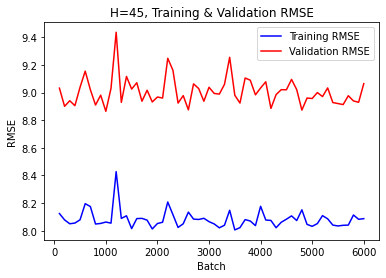

In [80]:
import matplotlib.pyplot as plt

# plot subtrain / validation RMSE
plt.plot(all_step, all_train_rmse, c='b', label='Training RMSE')
plt.plot(all_step, all_valid_rmse, c='r', label='Validation RMSE')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.title('H=45, Training & Validation RMSE')

In [81]:
# test RMSE
saved_mlp = torch.load(weight_path)
test_rmse = RMSE(saved_mlp, test_loader)
print(f'Test RMSE = {test_rmse}')

Test RMSE = 9.13611481105564


### Q3. H = 90, 180

In [83]:
for d_hidden in [90, 180]:
    
    d_input = subtrain_set.Xnp.shape[1]
    d_output = 1

    mlp = torch.nn.Sequential(
        torch.nn.Linear(d_input, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(d_hidden, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(d_hidden, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(d_hidden, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(d_hidden, d_output)
    )
    
    mlp = mlp.float()
    mlp.to(device)
    weight_path = f'./MLP{d_hidden}_weight'
    all_step, all_train_rmse, all_valid_rmse = train(model=mlp, optim=sgd_optimizer, loss_f=l2_loss, max_epoch=100, max_step=5000, valid_interval=100, weight_path=weight_path, train_rmse=False)
    saved_mlp = torch.load(weight_path)
    test_rmse = RMSE(saved_mlp, test_loader)
    print(f'H = {d_hidden}, Test RMSE = {test_rmse}\n')

Epoch 1, Step 418: Loss = 28942.1875, best_valid_rmse = 8.907746883502773
Epoch 2, Step 836: Loss = 27914.08984375, best_valid_rmse = 8.907746883502773
Epoch 3, Step 1254: Loss = 28417.09765625, best_valid_rmse = 8.879448549481122
Epoch 4, Step 1672: Loss = 28302.587890625, best_valid_rmse = 8.879448549481122
Epoch 5, Step 2090: Loss = 28317.279296875, best_valid_rmse = 8.879448549481122
Epoch 6, Step 2508: Loss = 29358.7421875, best_valid_rmse = 8.879448549481122
Epoch 7, Step 2926: Loss = 27203.46875, best_valid_rmse = 8.86669466895668
Epoch 8, Step 3344: Loss = 26493.2421875, best_valid_rmse = 8.86669466895668
Epoch 9, Step 3762: Loss = 28157.1015625, best_valid_rmse = 8.86669466895668
Epoch 10, Step 4180: Loss = 27017.103515625, best_valid_rmse = 8.86669466895668
Epoch 11, Step 4598: Loss = 27569.47265625, best_valid_rmse = 8.86669466895668
Epoch 12, Step 5016: Loss = 25447.50390625, best_valid_rmse = 8.831706841816834
Epoch 13, Step 5434: Loss = 26203.2109375, best_valid_rmse = 8.

(hidden dimension = 45: test RMSE = 9.136)  
**hidden dimension = 90: test RMSE = 9.078**  
**hidden dimension = 180: test RMSE = 9.132**

With test RMSE shown above, we suggest that providing 90 hidden nodes in the linear hidden layers performs the best. H=45 may construct a model too simple, while H=180 has a potential of overfitting.